In [1]:
!pip install datasets transformers evaluate sentencepiece accelerate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [2]:

from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base",num_labels = 5)
model = AutoModelForMaskedLM.from_pretrained("FacebookAI/roberta-base",num_labels = 5)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import torch

In [4]:
from datasets import Dataset
fin_df = pd.read_csv('/kaggle/input/sososoos/sos.csv',index_col=False)
fin_df.drop('embedding',axis =1,inplace = True)
sos_df=fin_df[['MessageText','SentimentScore_x']]
indexes_to_drop = sos_df[sos_df['SentimentScore_x'] == 0].index
sos_df = sos_df.drop(indexes_to_drop)
sos_df.rename(columns={'MessageText': 'text', 'SentimentScore_x': 'label'}, inplace=True)
sos_df['label'] = sos_df['label'].astype(int)
sos_df['label'] = sos_df['label'].apply(lambda x: x-1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# from datasets import load_dataset

# imdb = load_dataset("imdb")

In [7]:
# imdb,imdb["test"][0]

In [8]:

# from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base",num_labels = 5)
# model = AutoModelForMaskedLM.from_pretrained("FacebookAI/roberta-base",num_labels = 5)

In [9]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [10]:
# tokenized_imdb = imdb.map(preprocess_function, batched=True)

In [11]:
# tokenized_imdb,imdb

In [12]:
dataset = Dataset.from_pandas(sos_df)
if '__index_level_0__' in dataset.column_names:
    dataset = dataset.remove_columns('__index_level_0__')
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 9239
})


In [13]:
from datasets import Dataset, DatasetDict
train_df = sos_df.sample(frac=0.8, random_state=42)
test_df = sos_df.drop(train_df.index)
train_dataset = Dataset.from_pandas(train_df)
if '__index_level_0__' in train_dataset.column_names:
    train_dataset = train_dataset.remove_columns('__index_level_0__')
test_dataset = Dataset.from_pandas(test_df)
if '__index_level_0__' in test_dataset.column_names:
    test_dataset = test_dataset.remove_columns('__index_level_0__')
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7391
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1848
    })
})

In [14]:
# dataset_dict['train'][77]

In [15]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [16]:
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/7391 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

In [17]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7391
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1848
    })
})

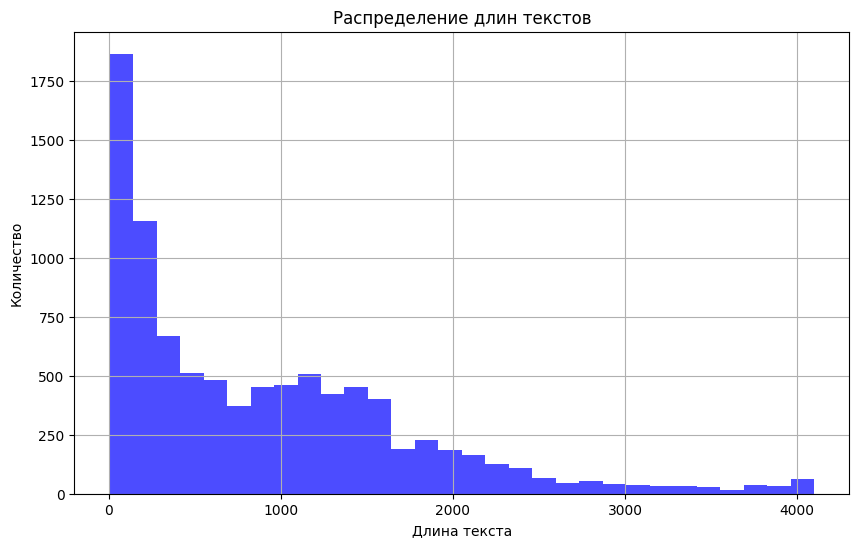

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
texts = [example['text'] for example in dataset] 
lengths = [len(text) for text in texts]
df = pd.DataFrame(lengths, columns=['Length'])
plt.figure(figsize=(10, 6))
plt.hist(df['Length'], bins=30, color='blue', alpha=0.7)
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.grid(True)
plt.show()


In [19]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2024-04-13 20:28:54.838830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 20:28:54.838962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 20:28:54.997541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7391
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1848
    })
})

In [21]:
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    predictions = np.argmax(predictions, axis=1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}


In [22]:
classes = set(tokenized_data["train"]['label'])
num_labels  = len(classes)

In [23]:
classes

{0, 1, 2, 3, 4}

In [24]:
id2label = {0: "УЖАСНО", 1: "ПЛОХО",2:"НОРМАЛЬНО",3:"ХОРОШО",4:"ОТЛИЧНО"}
label2id = {"УЖАСНО": 0, "ПЛОХО": 1,"НОРМАЛЬНО":2, "ХОРОШО":3, "ОТЛИЧНО":4}

In [25]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model_path = 'FacebookAI/roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(
    model_path, num_labels=num_labels, id2label=id2label, label2id=label2id,problem_type = "single_label_classification"
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
     tokenizer=tokenizer,
    data_collator=data_collator,  
    compute_metrics=compute_metrics,
)

trainer.train()


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.172000,1.087984,0.555736
2,1.073300,0.987650,0.587662
3,0.959700,0.994140,0.571429
4,0.939200,0.985154,0.583874
5,0.871000,0.978347,0.601190
6,0.836800,0.983298,0.606061
7,0.757700,1.088971,0.594156
8,0.732400,1.070798,0.597403
9,0.664100,1.118138,0.592532


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

KeyboardInterrupt: 

In [27]:
import torch
torch.save(model.state_dict(), "my_model.pth")


In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="stevhliu/my_awesome_model")
classifier(text)
